In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
)

train_dataset = torchvision.datasets.MNIST(
    root="./data", train=True, transform=transform, download=True
)
valid_dataset = torchvision.datasets.MNIST(
    root="./data", train=False, transform=transform, download=True
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=256, shuffle=True)
valid_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=256, shuffle=False)

loaders = {}
loaders["train"] = train_loader
loaders["valid"] = valid_loader

In [2]:
from src.collectors import DataCollector

COLLECTOR = DataCollector(metric_kwargs={'metric': 'correlation'})
NUM_EPOCHS = 2

In [3]:
# After https://pytorch.org/tutorials/beginner/introyt/trainingyt.html
# and https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#finetuning-the-convnet

from tqdm import tqdm


def train(model, loaders, criterion, optimizer, scheduler, num_epochs=5, device=torch.device('cpu')):
    model.to(device)

    for epoch in range(num_epochs):
        COLLECTOR.current_epoch = epoch

        train_loss, train_acc = one_epoch('train', model, loaders['train'], criterion, scheduler, optimizer, epoch, device)
        valid_loss, valid_acc = one_epoch('valid', model, loaders['valid'], criterion, scheduler, optimizer, epoch, device)

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_acc}")
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {valid_loss:.4f}, Accuracy: {valid_acc}")


def one_epoch(phase, model, loader, criterion, scheduler, optimizer, epoch_idx, device):
    if phase == 'train':
        model.train()
    elif phase == 'valid':
        model.eval()
    else:
        raise ValueError(
            f"Phase {phase} is not a proper learning phase (use 'train' or 'valid')!")

    running_loss = 0.0
    running_corrects = 0
    dataset_size = 0

    for batch, (inputs, labels) in enumerate(tqdm(loader)):
        COLLECTOR.current_batch = batch
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase == 'train'):
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            if phase == 'train':
                loss.backward()
                optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(predictions == labels.data)
        dataset_size += inputs.size(0)

        if phase == 'train' and scheduler is not None:
            scheduler.step()

    epoch_loss = running_loss / dataset_size
    epoch_acc = running_corrects / dataset_size

    return epoch_loss, epoch_acc

In [4]:
from torchinfo import summary

from src.modules.blocks import BasicBlock, PlainBlock
from src.modules.models import ResNet

model = ResNet(block=PlainBlock, in_channels=1, layers=[3, 4, 6, 3], num_classes=10)

summary(model)

Layer (type:depth-idx)                   Param #
ResNet                                   --
├─Conv2d: 1-1                            3,136
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
│    └─PlainBlock: 2-1                   --
│    │    └─Conv2d: 3-1                  36,864
│    │    └─BatchNorm2d: 3-2             128
│    │    └─ReLU: 3-3                    --
│    │    └─Conv2d: 3-4                  36,864
│    │    └─BatchNorm2d: 3-5             128
│    └─PlainBlock: 2-2                   --
│    │    └─Conv2d: 3-6                  36,864
│    │    └─BatchNorm2d: 3-7             128
│    │    └─ReLU: 3-8                    --
│    │    └─Conv2d: 3-9                  36,864
│    │    └─BatchNorm2d: 3-10            128
│    └─PlainBlock: 2-3                   --
│    │    └─Conv2d: 3-11                 36,864
│    │    └─BatchNorm2d: 3-12            12

In [5]:
import torch.nn as nn
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
scheduler = None
device = torch.device("mps")

train(model, loaders, criterion, optimizer, scheduler, NUM_EPOCHS, device)

  0%|          | 0/235 [00:00<?, ?it/s]


TypeError: parameters_distance() got an unexpected keyword argument 'metric_kwargs'

In [ ]:
for depth in range(1, model.max_depth + 1):
    print(depth, COLLECTOR.next_differences[depth][100])

1 0.01565784474951215
2 0.01997634334838949
3 0.02265589209855534
4 0.023439232812961563
5 0.037377061671577394
6 0.041211067233234644
7 0.03902787627885118
8 0.037021711556008086
9 0.04507084027864039
10 0.05040453444235027
11 0.05566347180865705
12 0.0541385889519006
13 0.06334283412434161
14 0.062405336648225784
15 0.06730519409757107
16 0.07584483502432704


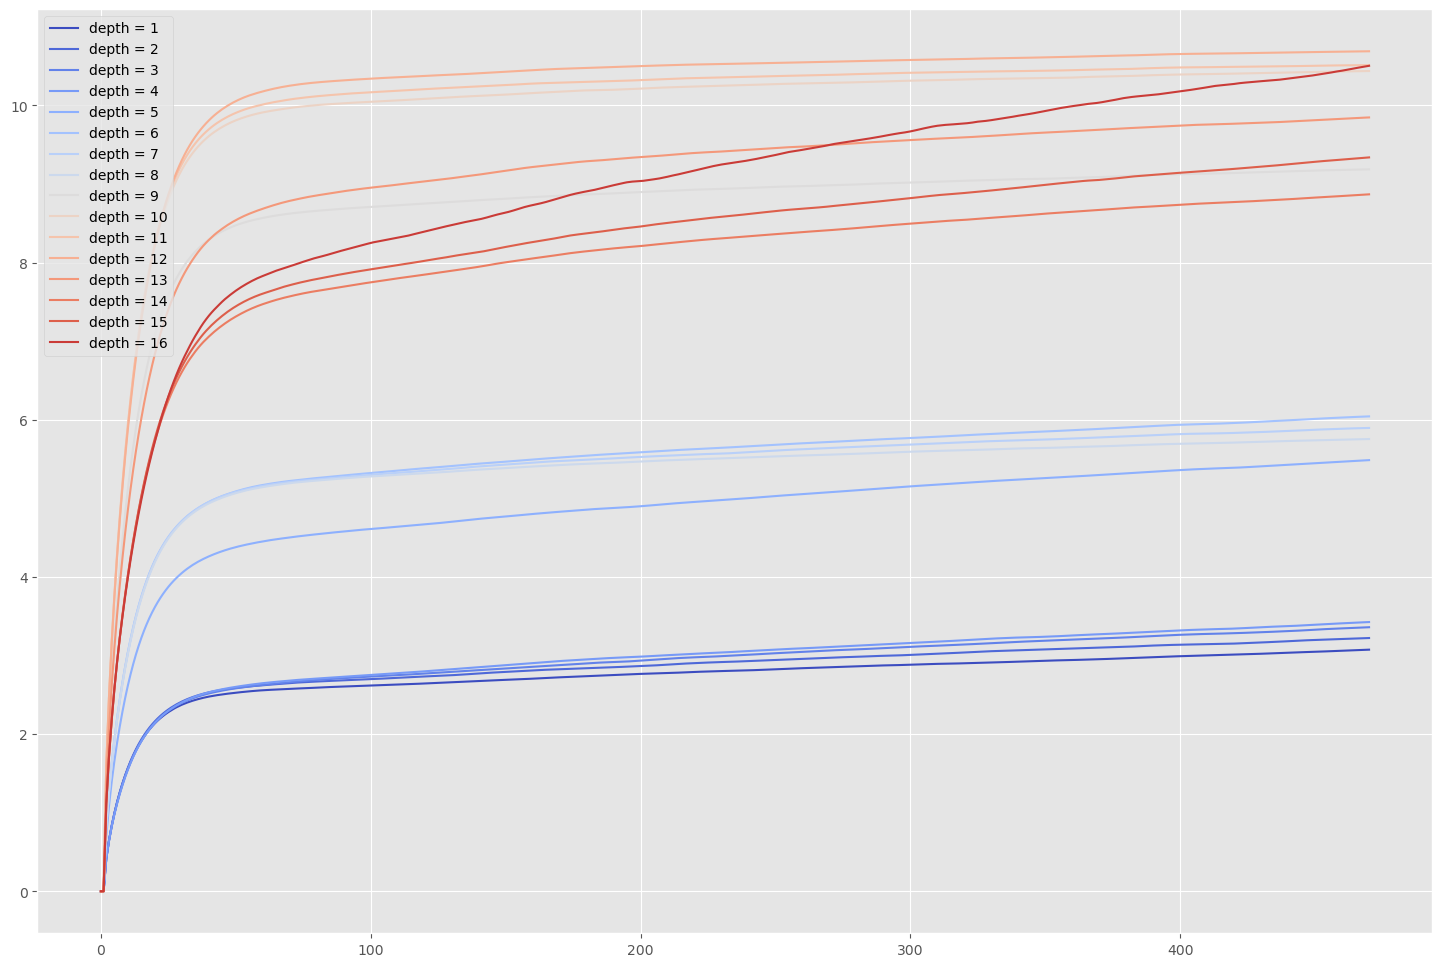

In [ ]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')

plt.figure(figsize=(18, 12))
for depth, differences in COLLECTOR.init_differences.items():
    plt.plot(differences, label=f"depth = {depth}", color=plt.cm.coolwarm((depth-1) / model.max_depth))
    
# plt.yscale('log')
plt.legend()
plt.show()


In [ ]:
# import os
# import pickle

# diff = {}
# init_diff = {}

# for depth in range(1, model.max_depth + 1):
#     for epoch in range(NUM_EPOCHS):
#         for batch in tqdm(range(len(train_loader) - 1)):
            
#             init_path = os.path.join("params", '0', "BasicBlock", f"{depth}", '0', "init.pkl")
#             with open(init_path, "rb") as f:
#                 init = pickle.load(f)
            
#             pre_path = os.path.join("params", str(epoch), "BasicBlock", f"{depth}", str(batch), "post-backward.pkl")
#             with open(pre_path, "rb") as f:
#                 pre = pickle.load(f)

#             post_path = os.path.join("params", "0", "BasicBlock", f"{depth}", str(batch + 1), "post-backward.pkl")
#             with open(post_path, "rb") as f:
#                 post = pickle.load(f)
                
#             if depth not in diff:
#                 diff[depth] = []
                
#             if depth not in init_diff:
#                 init_diff[depth] = []
                
#             diff[depth].append(parameters_distance(pre, post))
#             init_diff[depth].append(parameters_distance(init, post))